In [1]:
cd /Users/lucas/repositories/myDelfi

/Users/lucas/repositories/myDelfi


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from plotting import *
from ndes import *
from mdn import *

/usr/local/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [36]:
# import data
theta_ = (np.load('./borg-imnn/regression/results/regression_imnn_theta.npy').astype(np.float32))
summaries_ = np.load('./borg-imnn/regression/regression_imnn_x.npy').astype(np.float32)

def get_S8(omegam, sigma8):
    return sigma8 * np.sqrt(omegam / 0.3)

# summaries_[:, 0] = get_S8(summaries_[:, 0], summaries_[:, 1])
# theta_[:, 0]  = get_S8(theta_[:, 0], theta_[:, 1])


theta_ = (np.load('./borg-imnn/regression/results/results_wiener/theta_reg_S8_wiener2.npy').astype(np.float32))
summaries_ = np.load('./borg-imnn/regression/results/results_wiener/x_reg_S8_wiener2.npy').astype(np.float32)






max_S8 = 2.720
min_S8 = 0.24


#summaries_ = summaries_.reshape(summaries_.shape[0], 4)

weights = np.ones((summaries_.shape[0], 1)).astype(np.float32)




# bijector theta -> phi
theta_min = [min_S8, 0.35]
theta_max = [max_S8 + 0.05, 1.65]
bijector = tfb.Blockwise([tfb.Chain([tfb.Invert(tfb.NormalCDF()), tfb.Scale(np.float32(1./(theta_max[_] - theta_min[_]))), tfb.Shift(-theta_min[_])]) for _ in range(len(theta_min))])

# phi
phi_ = bijector(theta_).numpy()

In [37]:
theta_[:, 0].min(), theta_[:, 0].max()

(0.24785069, 2.7173748)

In [38]:
theta_.shape, summaries_.shape, phi_.shape

((2000, 2), (2000, 2), (2000, 2))

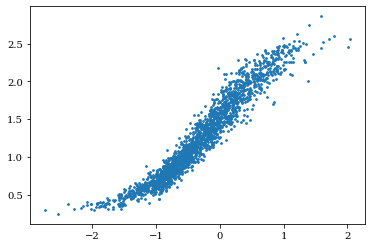

In [39]:
plt.scatter(phi_[:, 0], (summaries_[:, 0]), s=3)
#plt.axvline(0.27, color='k')
plt.show()

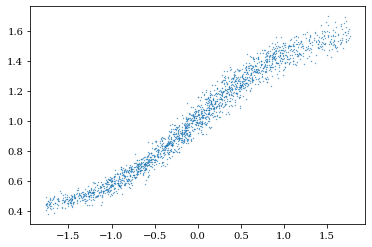

In [40]:
plt.scatter(phi_[:,1], (summaries_[:,1]), s=0.1)
plt.show()

In [41]:
theta = tf.convert_to_tensor(theta_, dtype=tf.float32)
phi   = tf.convert_to_tensor(phi_, dtype=tf.float32)
weights = tf.convert_to_tensor(weights, dtype=tf.float32)
summaries = tf.convert_to_tensor(summaries_, dtype=tf.float32)

In [42]:
# Amortized posterior
filename = './borg-imnn/regression/results/results_wiener/amortized_post_s8'
AmortizedPosterior = MixtureDensityNetwork2(n_components=3, 
                            n_conditionals=2, 
                            n_dimensions=2, 
                            optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                            n_hidden=[64, 64],
                            activation=[tf.tanh, tf.tanh])

/usr/local/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [88]:
AmortizedPosterior.optimizer = tf.keras.optimizers.Adam(lr=1e-4)
historyAP = AmortizedPosterior.fit(training_conditionals=summaries, training_variables=phi, training_weights=weights, 
                        epochs=3000, batch_size=256, patience=500, save=True, filename=filename)

 22%|██▏       | 654/3000 [00:24<01:27, 26.80it/s, training loss=-.028, validation_loss=-.000958]  


In [89]:
# reload best model
AmortizedPosterior = MixtureDensityNetwork2(n_components=3, 
                            n_conditionals=4, 
                            n_dimensions=2, 
                            optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                            n_hidden=[50, 100],
                            activation=[tf.tanh, tf.tanh],
                            restore=True,
                            restore_filename=filename)

In [90]:
pwd

'/Users/lucas/repositories/myDelfi'

In [91]:
#obs_summs = np.array([0.3063951, 0.7823376])
#obs_summs[0] = get_S8(obs_summs[0], obs_summs[1])

summaries_obs = np.array([0.8150863 , 0.77163243])#np.load("borg-imnn/regression/results/results_wiener/reg_estimates_S8_wiener2.npy")

In [92]:
# plot over a grid
omegaM = np.linspace(min_S8, max_S8, 70)
sigma8 = np.linspace(0.41, 1.6, 110)
OM, S8 = np.meshgrid(omegaM, sigma8)
theta_grid = np.concatenate([OM[...,np.newaxis], S8[...,np.newaxis]], axis=-1)
phi_grid = bijector(theta_grid)

cond_shape = theta_grid.shape[:-1] + (2,)

log_prob = tf.squeeze(AmortizedPosterior.log_prob(phi_grid, conditional=summaries_obs*np.ones(cond_shape).astype(np.float32))).numpy()
#log_prob = SamplingDistribution.log_prob(summaries_obs*np.ones(phi_grid.shape).astype(np.float32), conditional=theta_grid).numpy()
log_prob = log_prob - max(log_prob.flatten())

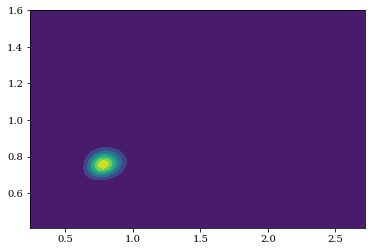

In [93]:
plt.contourf(omegaM, sigma8, np.exp(log_prob))
plt.show()

In [94]:
np.std(theta[:,0])

0.5469495

In [95]:
def get_OmegaM(S8, sigma8):
    return 0.3*(S8 / sigma8)**2

In [96]:
Posterior = AmortizedPosterior.distribution(summaries_obs[np.newaxis, :].astype(np.float32))

posterior_samples = bijector.inverse(Posterior.sample(100000)).numpy()
cut = np.all(~np.isinf(posterior_samples), axis=-1)
posterior_samples = posterior_samples[cut,:]

posterior_samples[:, 0] = get_OmegaM(posterior_samples[:, 0], posterior_samples[:, 1])

# cut = posterior_samples[:, 0] < 0.8
# posterior_samples = posterior_samples[cut, :]

# cut = posterior_samples[:, 0] > 0.1
# posterior_samples = posterior_samples[cut, :]

In [97]:
posterior_samples.shape

(100000, 2)

(array([1.3029e+04, 6.2518e+04, 2.2192e+04, 2.1390e+03, 1.1400e+02,
        2.0000e+00, 0.0000e+00, 2.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([0.12515615, 0.24805392, 0.37095168, 0.49384946, 0.6167472 ,
        0.739645  , 0.86254275, 0.98544055, 1.1083384 , 1.2312361 ,
        1.3541338 ], dtype=float32),
 <BarContainer object of 10 artists>)

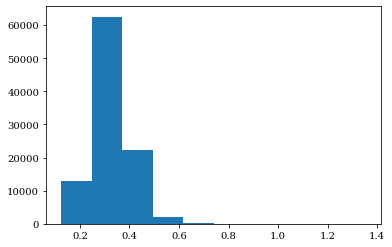

In [98]:
plt.hist(posterior_samples[:, 0])

In [99]:
#np.save('./borg-imnn/regression/results/posterior_samples_S8_3', posterior_samples)

In [100]:
import numpy as np
import h5py as h5
import matplotlib.pylab as plt
from scipy.stats import gaussian_kde

def get_data_borg(f,start):
    A1 = f['A1']
    bTA = f['bTA']
    A2 = f['A2']
    omegaM = f['omegaM']
    sigma8 = f['sigma8']
    h100 = f['h']
    return A1[start:], bTA[start:], A2[start:], omegaM[start:], h100[start:], sigma8[start:]

omegaM,sigma8,h100 = np.load("/Users/lucas/repositories/IMNN_vs_BORG/posterior_plots/borg_posterio_twoparam.npy").T

g = np.load('/Users/lucas/repositories/IMNN_vs_BORG/borg_runs_fixed_IA_fixed_h.npz')
A1,bTA,A2,omegaM,h100,sigma8 = get_data_borg(g,0)

omegaM_cls, s8_cls, *_ = np.load("/Users/lucas/repositories/IMNN_vs_BORG/samples_noIA.npy").T


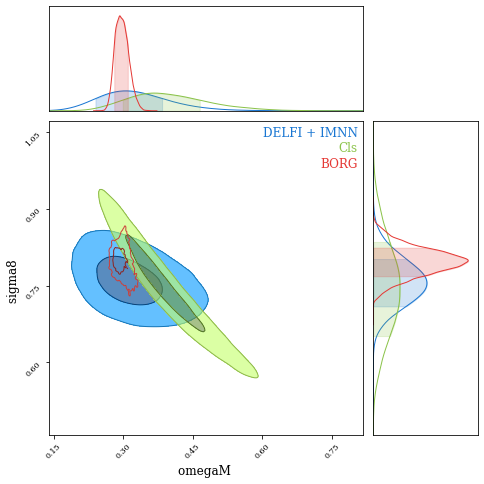

In [101]:
from chainconsumer import ChainConsumer

_psts = posterior_samples.copy()
#_psts[:, 0] = 0.3*(posterior_samples[:, 0]**2 / posterior_samples[:, 1]**2)

cs = ChainConsumer()
cs.add_chain(_psts, parameters=['omegaM', 'sigma8'], name='DELFI + IMNN') #, color=corner_colors[0])

cs.add_chain(np.stack([omegaM_cls, s8_cls], -1), parameters=['omegaM', 'sigma8'], name='Cls') #, color=corner_colors[0])

cs.add_chain(np.stack([omegaM, sigma8], axis=-1), parameters=['omegaM', 'sigma8'], name='BORG')

cs.configure(linestyles=["-", "-", "-"], linewidths=[1.0, 1.0, 1.0], usetex=False,
        shade=[True, True, False], shade_alpha=[0.7, 0.6, 0.], tick_font_size=8, sigma2d=True)
cs.plotter.plot((7,7))
plt.show()

# now set up PIT coverage tests

for every pair (theta*, data*) in the training set, for each of the marginals compute P(theta < theta* | data*), and plot the distribution of those cumulative probabilities

In [102]:
from tqdm import tqdm

In [103]:
omegam_cdfs = []
sigma8_cdfs = []

for i in tqdm(range(2000)):
  theta_i = theta_[i]
  summary_i = summaries_[i]
  # could add tfp mixture model here for more than one MDN
  # p(theta | x)
  dist = AmortizedPosterior.distribution(summary_i[np.newaxis, :].astype(np.float32))
  
  samps = bijector.inverse(dist.sample(100000)).numpy()
  cut = np.all(~np.isinf(samps), axis=-1)
  samps = samps[cut,:]
  norm = samps.shape[0]


  #for each marginal
  omegam_cdfs.append(np.sum(samps[:, 0] <= theta_i[0]) / norm) 
  sigma8_cdfs.append(np.sum(samps[:, 1] <= theta_i[1]) / norm)

  #plt.hist(samps[:, 1])
  #plt.axvline(theta_i[:, 1])
  
  

100%|██████████| 2000/2000 [02:27<00:00, 13.57it/s]


In [104]:
bins = 20
nsamps = 2000

uniform_layer = nsamps / bins
std = np.sqrt(uniform_layer)

Text(0.5, 0, '$\\sigma_8$-PIT')

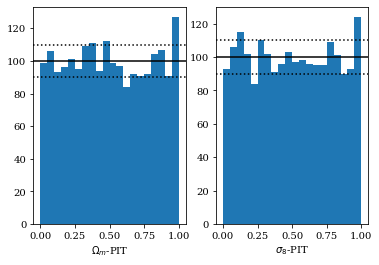

In [105]:
plt.subplot(121)
plt.hist(omegam_cdfs, bins=bins, density=False)
plt.axhline(uniform_layer, color='k')
plt.axhline(uniform_layer - std, color='k', ls=':')
plt.axhline(uniform_layer + std, color='k', ls=':')

plt.xlabel(r'$\Omega_m$-PIT')

plt.subplot(122)
plt.hist(sigma8_cdfs, bins=bins, density=False)
plt.axhline(uniform_layer, color='k')

plt.axhline(uniform_layer - std, color='k', ls=':')
plt.axhline(uniform_layer + std, color='k', ls=':')

plt.xlabel(r'$\sigma_8$-PIT')